In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import ARDL
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import ARDL

file_path = '/content/drive/MyDrive/UK macro data/CPI UK.csv'
df = pd.read_csv(file_path, index_col=0, skiprows=5, header=None)

# Rename the single column for clarity
df.columns = ['Index Price']

# Find the index of '1988 Q1' and '2024 Q4'
start_index = df.index.get_loc('1988 Q1')
end_index = df.index.get_loc('2024 Q4')  # Find the index of '2024 Q4'

# Slice the DataFrame to include the desired rows
df_sliced = df.iloc[start_index:end_index+1]

# Convert index to 'yyyymm' format and reset index
def convert_index_to_yyyymm(index_label):
    year, quarter = index_label.split()
    quarter_month = {'Q1': '03', 'Q2': '06', 'Q3': '09', 'Q4': '12'}
    return year + quarter_month[quarter]

df_sliced.index = df_sliced.index.map(convert_index_to_yyyymm)
df_sliced.reset_index(inplace=True)
df_sliced.columns = ['date', 'Index Price']  # Renaming columns properly

# Display the transformed DataFrame
df_sliced


,date,Index Price
0,198803,48.6
1,198806,49.5
2,198809,49.9
3,198812,50.5
4,198903,51.0
...,...,...
143,202312,132.0
144,202403,132.3
145,202406,133.8
146,202409,134.1


<ipython-input-25-c3eac30c3953>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sliced['Index Price'] = pd.to_numeric(df_sliced['Index Price'])
<ipython-input-25-c3eac30c3953>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sliced['Annual Inflation Rate'] = 400 * np.log(df_sliced['Index Price'] / df_sliced['Index Price'].shift(1))


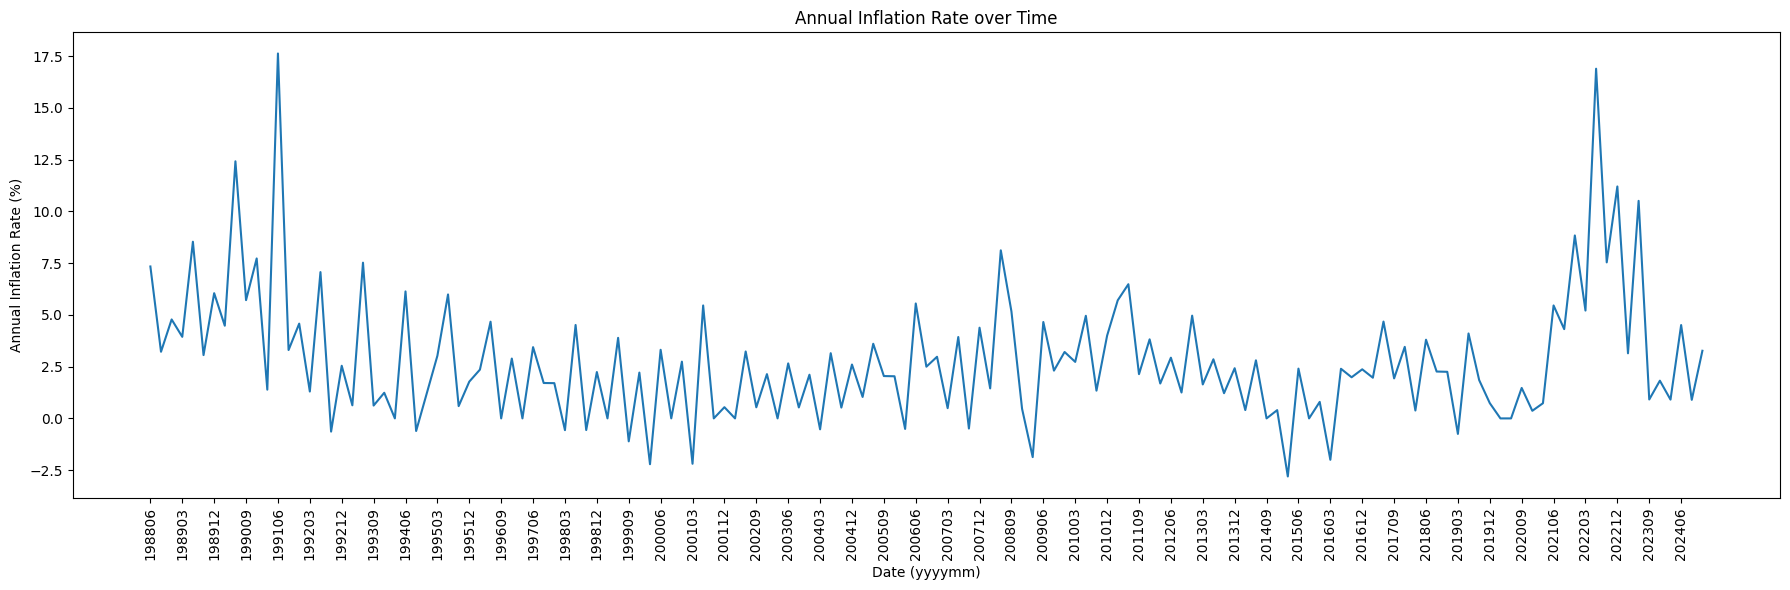

In [25]:
# Convert 'Index Price' column to numeric
df_sliced['Index Price'] = pd.to_numeric(df_sliced['Index Price'])

# Calculate one-quarter (annualized) inflation rate
df_sliced['Annual Inflation Rate'] = 400 * np.log(df_sliced['Index Price'] / df_sliced['Index Price'].shift(1))

# Drop the rows with NaN values due to the shift operation
df_inflation = df_sliced.dropna(subset=['Annual Inflation Rate'])

# Display the resulting DataFrame
df_inflation

import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
plt.plot(df_inflation['date'], df_inflation['Annual Inflation Rate'])

# Set labels
plt.xlabel('Date (yyyymm)')
plt.ylabel('Annual Inflation Rate (%)')
plt.title('Annual Inflation Rate over Time')

# Display x-axis labels every 3rd point
plt.xticks(df_inflation['date'][::3], rotation=90)

# Adjust layout
plt.tight_layout()
plt.show()


In [5]:
df_inflation


,date,Index Price,Annual Inflation Rate
1,198806,49.5,7.339655
2,198809,49.9,3.219333
3,198812,50.5,4.780933
4,198903,51.0,3.940919
5,198906,52.1,8.535726
...,...,...,...
143,202312,132.0,1.822327
144,202403,132.3,0.908059
145,202406,133.8,4.509631
146,202409,134.1,0.895857


# **Stationary Test with ADF for annual CPI inflation Rate, from the result we get stationary with 9% confidence level (p-value 0.0178)**



In [6]:


from statsmodels.tsa.stattools import adfuller

# Extract the Annual Inflation Rate series
inflation_rate_series = df_inflation['Annual Inflation Rate']

# Perform the ADF test
adf_result = adfuller(inflation_rate_series)

# Display the results
adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '# of Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

print("Augmented Dickey-Fuller Test Results:")
print(adf_output)



Augmented Dickey-Fuller Test Results:
Test Statistic                  -3.239935
p-value                          0.017786
# of Lags Used                  12.000000
Number of Observations Used    134.000000
Critical Value (1%)             -3.480119
Critical Value (5%)             -2.883362
Critical Value (10%)            -2.578407
dtype: float64


# ** In paper terminology there is average inflation, but we do not need to use average, furthermore because the data is stationary already, we do not need to take differencing anymore**




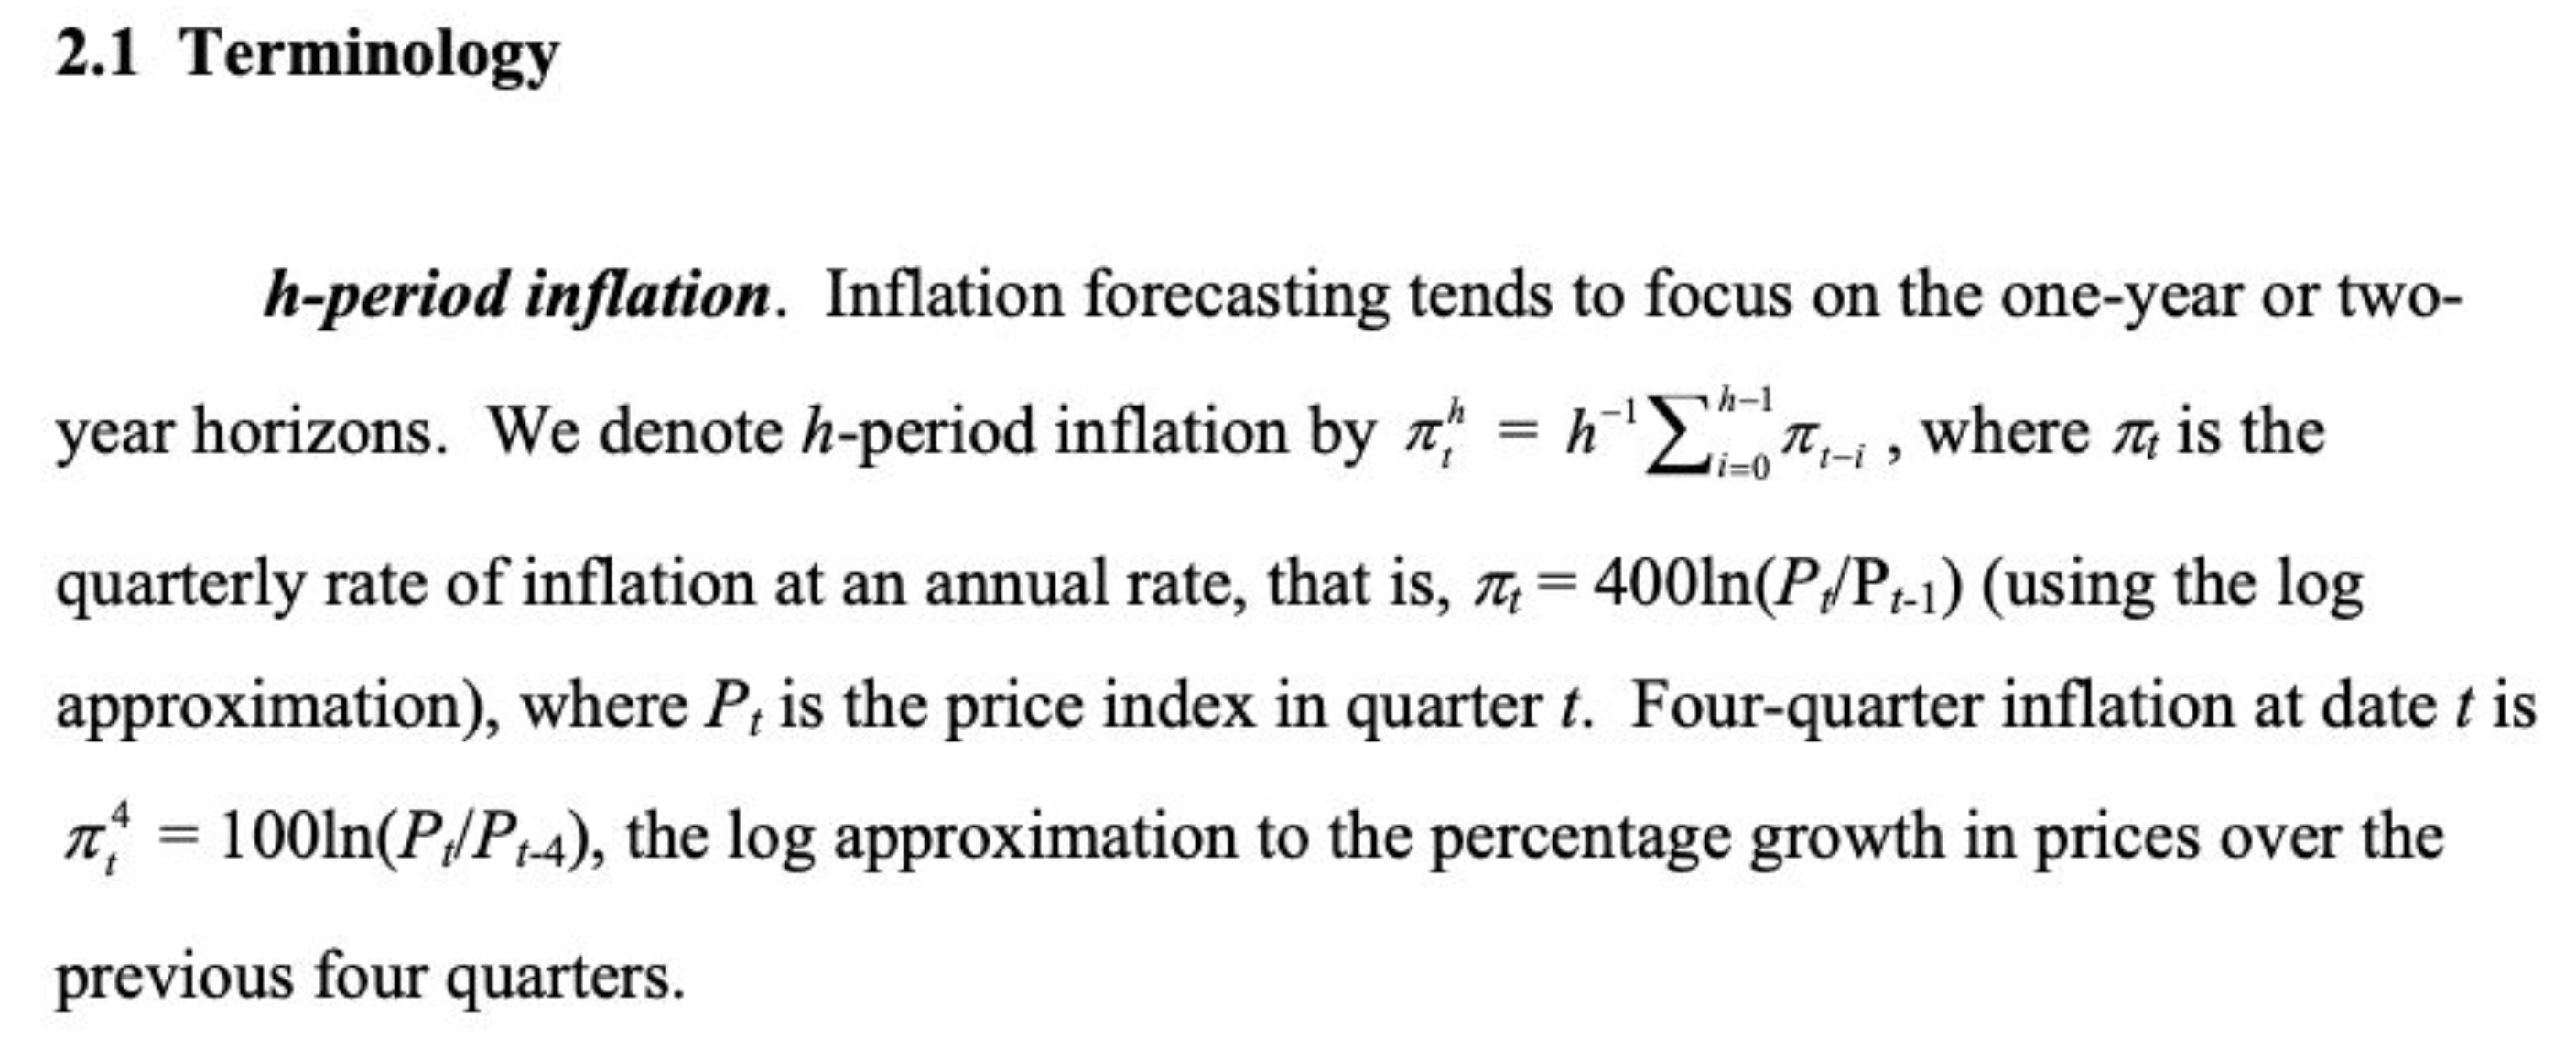

Do we have to take average of infation rate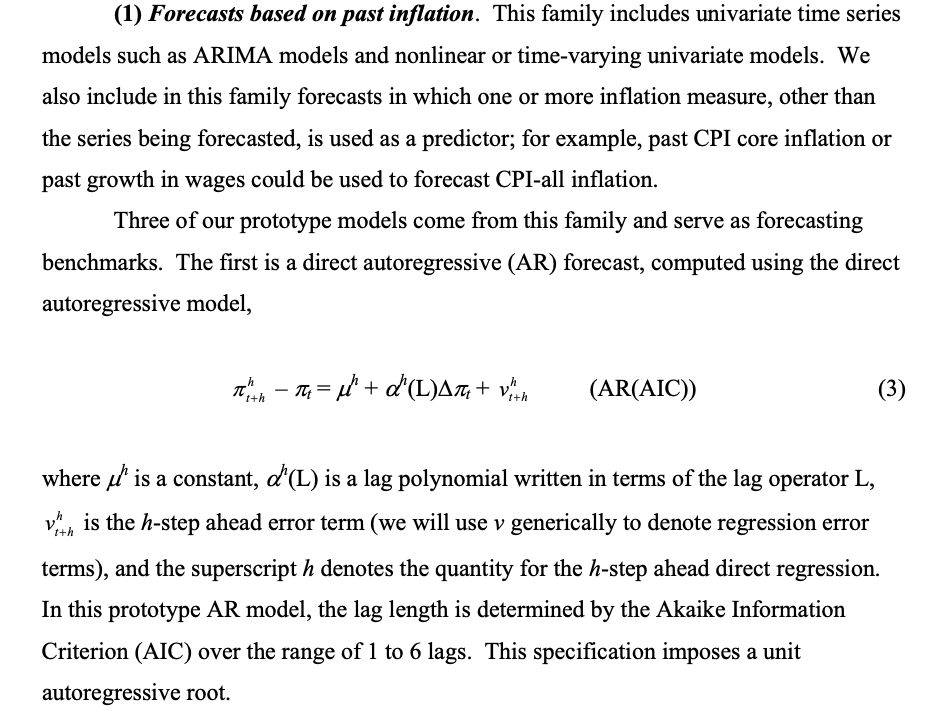

what if the data is stationary already?

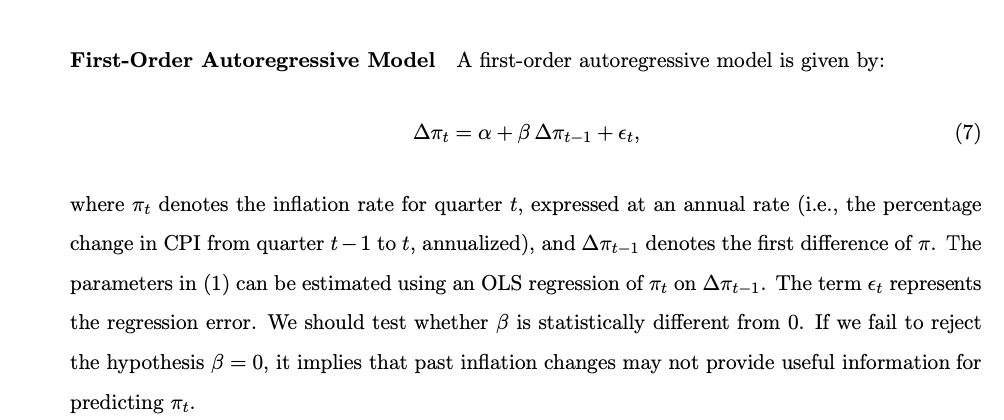

# **We can see the data is correlated between its lag with ACF plot and Cutoff determination with PACF to determine the best AR lag, which in here is at lag 6**


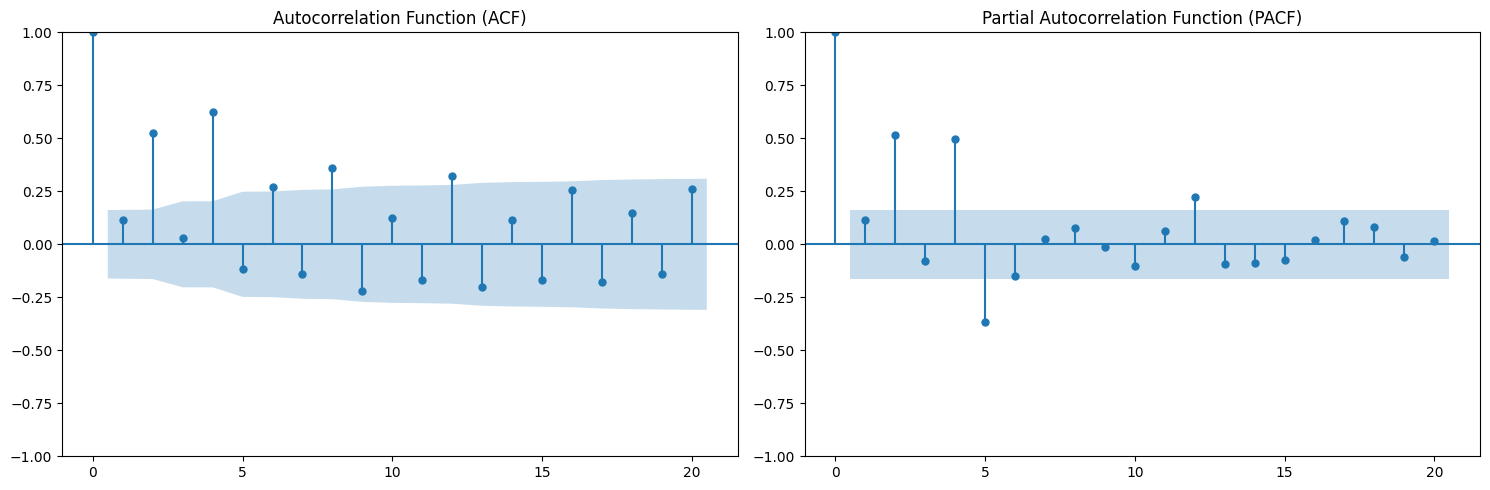

In [7]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting the ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ACF Plot
plot_acf(inflation_rate_series, lags=20, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF Plot
plot_pacf(inflation_rate_series, lags=20, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()



# **ORiginal AR analysis,along with residual ACF Plot & LB test to check the residual is iid and homoscedasticity for AR(1) and AR(6), we get heterocedasticity for AR(1) because there is correlation between residual in ACF plot and lb test p value is really low,

#However with AR(6) we get good result with p value above 95 % confidence level and ACF plot residual is below the threshold at 95% confidence level, therefore we chose AR(6) as the best model **

#AR(1) coefficient p value is also insignificant but some AR(6) p-value is significant at 95% confidence level)

---

**bold text**

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf

def calculate_AR_model(df_inflation, lags):

    # Extract the 'Annual Inflation Rate' column
    inflation_rates = df_inflation['Annual Inflation Rate']

    # Fit the AR model
    model = AutoReg(inflation_rates, lags=lags)
    model_fit = model.fit()

    # Print the model summary
    print(model_fit.summary())

    # Get the AR coefficients (excluding the intercept term)
    ar_coef = model_fit.params[1:]

    # Print AR coefficients
    print("\nAR Coefficients:")
    print(ar_coef)

    # Get the residuals
    residuals = model_fit.resid

    # Plot the ACF of residuals
    plt.figure(figsize=(12, 6))
    plot_acf(residuals, lags=12, alpha=0.05)
    plt.title("Autocorrelation Function (ACF) of Residuals")
    plt.show()

    # Perform the Ljung-Box test on residuals
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    print("Ljung-Box Test Results for Residuals:")
    print(lb_test)

    # Return results
    return model_fit, ar_coef, lb_test, residuals


                              AutoReg Model Results                              
Dep. Variable:     Annual Inflation Rate   No. Observations:                  147
Model:                        AutoReg(1)   Log Likelihood                -372.797
Method:                  Conditional MLE   S.D. of innovations              3.110
Date:                   Fri, 04 Apr 2025   AIC                            751.595
Time:                           02:32:14   BIC                            760.546
Sample:                                1   HQIC                           755.232
                                     147                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        2.4314      0.343      7.086      0.000       1.759       3.104
Annual Inflation Rate.L1     0.1156      0.082      1.416      0.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


<Figure size 1200x600 with 0 Axes>

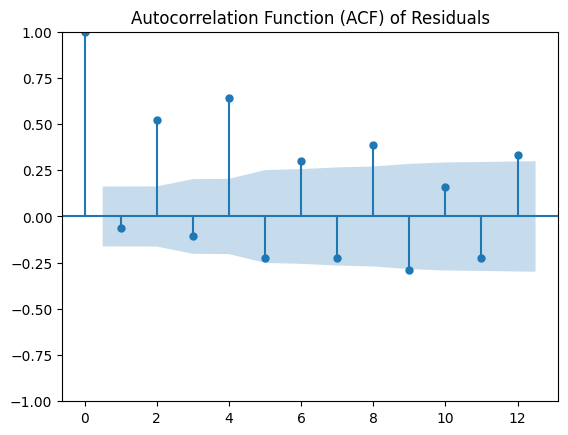

Ljung-Box Test Results for Residuals:
       lb_stat     lb_pvalue
10  176.227762  1.420794e-32


In [9]:
model_fit, ar_coef, lb_test, residuals = calculate_AR_model(df_inflation, lags=1)


                              AutoReg Model Results                              
Dep. Variable:     Annual Inflation Rate   No. Observations:                  147
Model:                        AutoReg(6)   Log Likelihood                -305.654
Method:                  Conditional MLE   S.D. of innovations              2.114
Date:                   Fri, 04 Apr 2025   AIC                            627.307
Time:                           02:32:14   BIC                            650.897
Sample:                                6   HQIC                           636.893
                                     147                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.9765      0.308      3.170      0.002       0.373       1.580
Annual Inflation Rate.L1     0.2769      0.083      3.319      0.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


<Figure size 1200x600 with 0 Axes>

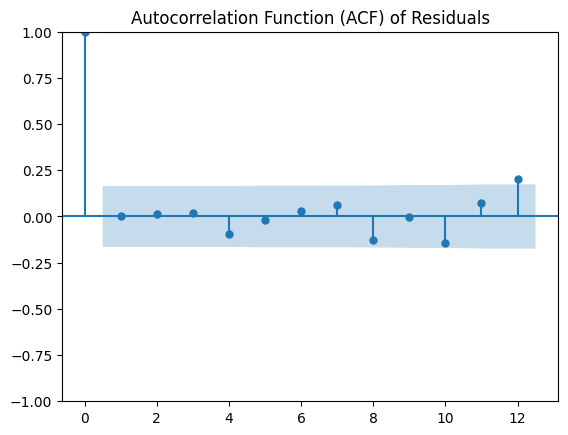

Ljung-Box Test Results for Residuals:
     lb_stat  lb_pvalue
10  7.831293   0.645312


In [10]:
model_fit, ar_coef, lb_test, residuals = calculate_AR_model(df_inflation, lags=6)

#Linear State Space Model of AR(6)

In [ ]:
#!pip install quantecon  #toinstall remove#

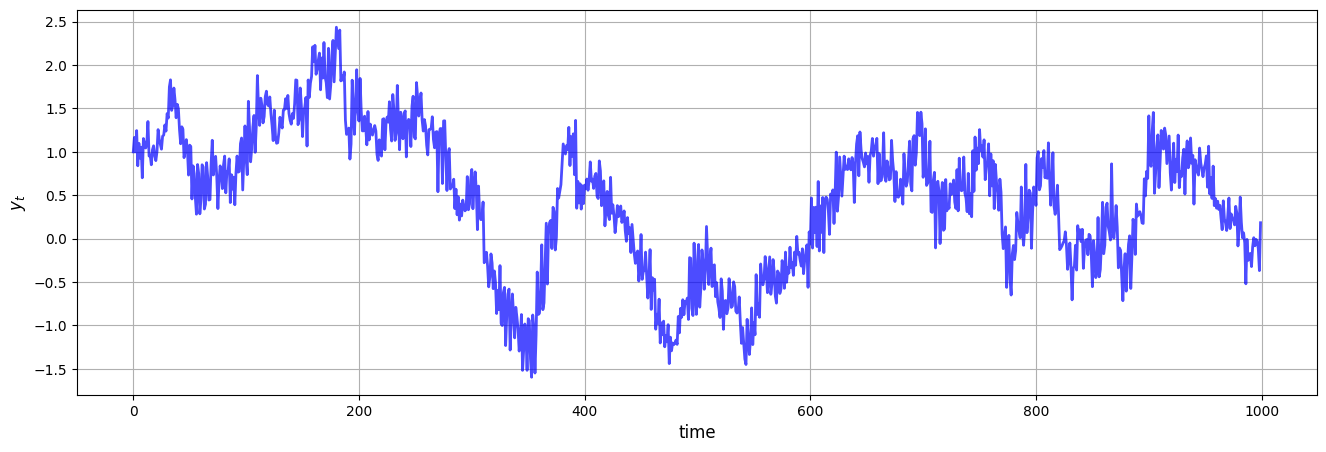

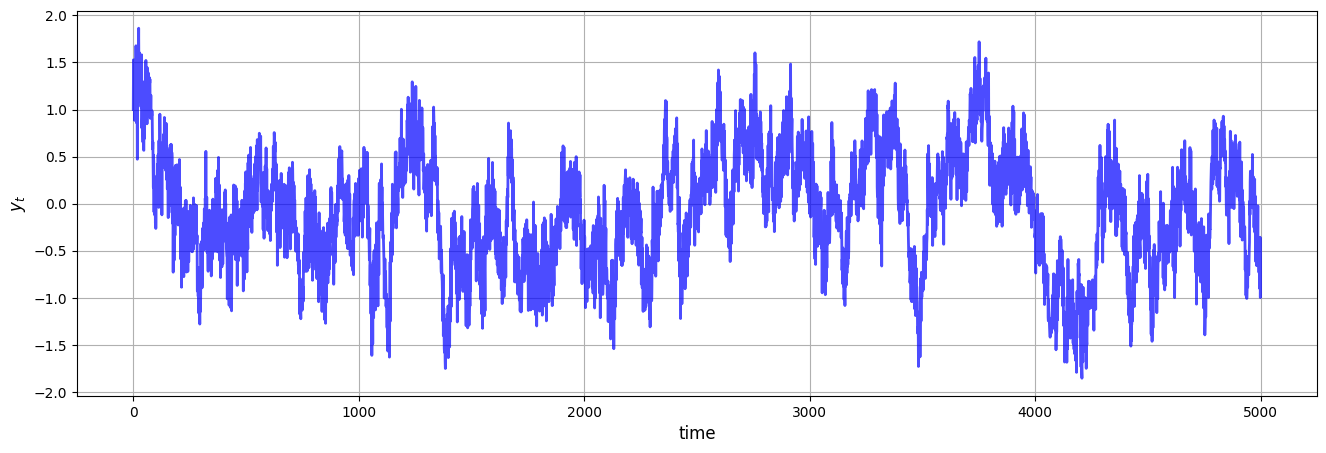

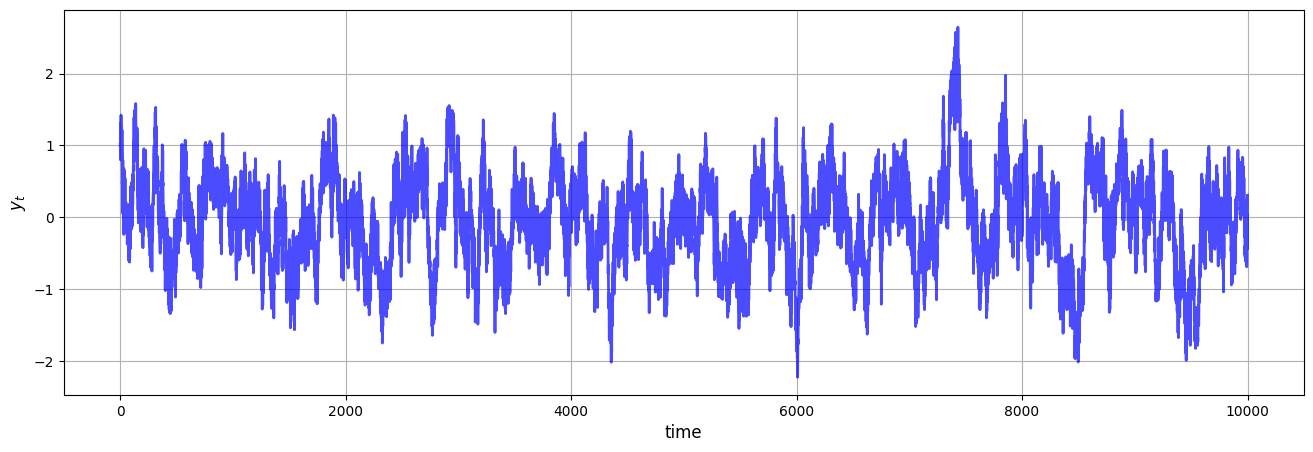

In [34]:
# 1. Import the LinearStateSpace class.


from quantecon import LinearStateSpace


import numpy as np
import matplotlib.pyplot as plt

# 4. Define a wrapper function.

def plot_lss(A, C, G, n, ts_length):

    ar = LinearStateSpace(A, C, G, mu_0=np.ones(n))  # what about Sigma_0?
    x, y = ar.simulate(ts_length,random_state=None)  # recall how random number is generated.

    fig, ax = plt.subplots(1,1,figsize=(16,5))
    y = y.flatten()
    ax.plot(y, 'b-', lw=2, alpha=0.7)
    ax.grid()
    ax.set_xlabel('time', fontsize=12)
    ax.set_ylabel('$y_t$', fontsize=12)
    plt.show()


phi_1, phi_2, phi_3, phi_4, phi_5, phi_6, sigma = 0.276931, 0.286270, 0.286270, 0.578234, -0.325854, -0.136724 ,0.2

A1 = [[phi_1, phi_2, phi_3, phi_4, phi_5, phi_6],
      [1,     0,     0,     0 , 0, 0   ],
      [0,     1,     0,     0, 0, 0    ],
      [0,     0,     1,     0, 0, 0    ],
      [0,     0,     0,     1, 0, 0    ],
      [0,     0,     0,     0, 1, 0    ],
      ]

C1 = [[sigma],[0],[0],[0], [0], [0]]


G1 = [1, 0, 0, 0, 0, 0]

plot_lss(A1, C1, G1, n=6, ts_length = 1000)
plot_lss(A1, C1, G1, n=6, ts_length = 5000)
plot_lss(A1, C1, G1, n=6, ts_length = 10000)

#TESTING FOR ARCH EFFECT for AR(6), indicate there is no arch effect with 95% confidence level

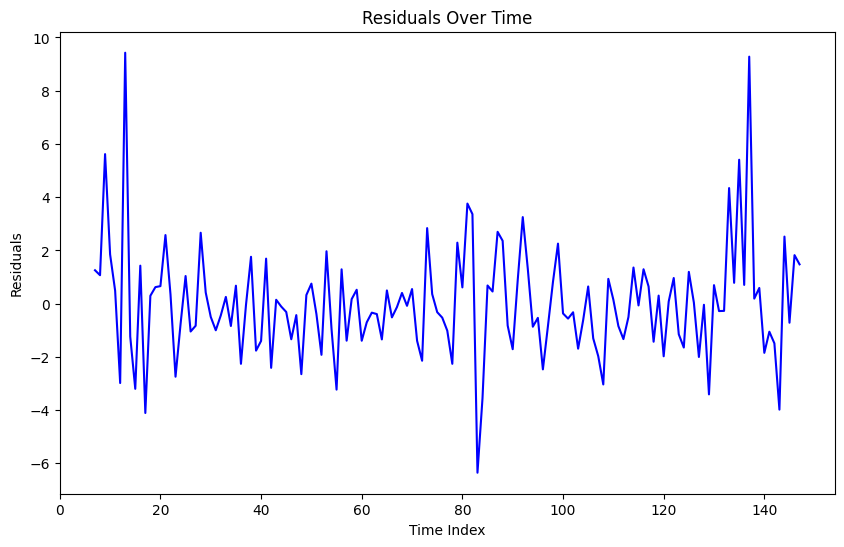

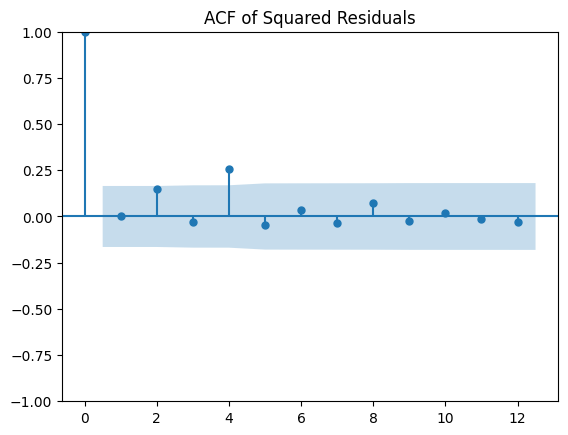

ARCH Test Results:
LM Statistic      11.700579
p-value            0.305595
F-statistic        1.176929
F-test p-value     0.313032
dtype: float64


In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.tsaplots import plot_acf

# Plot the residuals to visually inspect for volatility clustering
plt.figure(figsize=(10, 6))
plt.plot(residuals, color='blue')
plt.title('Residuals Over Time')
plt.xlabel('Time Index')
plt.ylabel('Residuals')
plt.show()

# Plot the ACF of squared residuals (common way to detect ARCH effects)
plot_acf(residuals ** 2, lags=12, alpha = 0.05)
plt.title('ACF of Squared Residuals')
plt.show()

# Perform the ARCH-LM Test
arch_test = het_arch(residuals)
arch_test_results = pd.Series(arch_test, index=['LM Statistic', 'p-value', 'F-statistic', 'F-test p-value'])

print("ARCH Test Results:")
print(arch_test_results)


#we try to compute AIC BIC for different lag, and we get lower AIC BIC everytime we increase the lag. However based on PACF cutoff, it will be better to choose only at 6 lag due to avoid overfitting

In [12]:

import pandas as pd

results = []
for i in range(1, 10):  # AR models from lag 1 to 9

    model = AutoReg(inflation_rate_series, lags=i)
    model_fit = model.fit()
    aic = model_fit.aic
    bic = model_fit.bic
    results.append([i, aic, bic])
    print(f"AR({i}): AIC={aic:.2f}, BIC={bic:.2f}")

# Find the best models based on AIC and BIC
results_df = pd.DataFrame(results, columns=['Lag', 'AIC', 'BIC'])
best_aic_model = results_df.loc[results_df['AIC'].idxmin()]  # Find row with minimum AIC
best_bic_model = results_df.loc[results_df['BIC'].idxmin()]  # Find row with minimum BIC


print(f"\nBest Model (AIC): Lag {int(best_aic_model['Lag'])}, AIC={best_aic_model['AIC']:.2f}, BIC={best_aic_model['BIC']:.2f}")
print(f"Best Model (BIC): Lag {int(best_bic_model['Lag'])}, AIC={best_bic_model['AIC']:.2f}, BIC={best_bic_model['BIC']:.2f}")

AR(1): AIC=751.59, BIC=760.55
AR(2): AIC=703.41, BIC=715.32
AR(3): AIC=700.57, BIC=715.42
AR(4): AIC=656.06, BIC=673.84
AR(5): AIC=631.38, BIC=652.07
AR(6): AIC=627.31, BIC=650.90
AR(7): AIC=625.57, BIC=652.04
AR(8): AIC=622.26, BIC=651.60
AR(9): AIC=613.34, BIC=645.54

Best Model (AIC): Lag 9, AIC=613.34, BIC=645.54
Best Model (BIC): Lag 9, AIC=613.34, BIC=645.54


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot

# This section will train and predict data with AR(1) adn AR(6) model where we separate train and test data, we get the best prediction model with AR(6) compared to AR(1) date is split in before and after Jun 2022

#Data prediction for AR(1) is constant horizontal line, our assumption is that because the AR(1) coefficient is not significant, so it will only contain constant value


In [13]:
import pandas as pd
import numpy as np


df_inflation_prediction = df_inflation.copy()

# Convert the 'date' column to datetime format and set it as the index in the new DataFrame
df_inflation_prediction['date'] = pd.to_datetime(df_inflation_prediction['date'], format='%Y%m')
df_inflation_prediction.set_index('date', inplace=True)

# Define Train and Test Sets
train_data = df_inflation_prediction.loc[df_inflation_prediction.index <= '2022-06-01', 'Annual Inflation Rate']
test_data = df_inflation_prediction.loc[df_inflation_prediction.index > '2022-06-01', 'Annual Inflation Rate']


#function definition

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

def fit_and_predict_AR_model(lags):
    # Fit the AR model on the training data
    model = AutoReg(train_data, lags=lags)
    model_fit = model.fit()

    # Print the model summary
    print(model_fit.summary())

    # Make predictions for the test data
    predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=True)

    print(predictions)
    predictions.index = test_data.index


   # Plot the results
    plt.figure(figsize=(18, 6))

    # Use the date index for plotting
    plt.plot(train_data.index, train_data, label='Training Data', color='blue')
    plt.plot(test_data.index, test_data, label='Actual Inflation Rate', color='green')
    plt.plot(test_data.index, predictions, label='Predicted Inflation Rate', color='red', linestyle='dashed')

    plt.title(f'Predicted vs Actual Inflation Rate with AR({lags})')
    plt.xlabel('Date (yyyymm)')
    plt.ylabel('Annual Inflation Rate')
    plt.legend()

    # Set x-axis ticks to display all dates without skipping
    plt.xticks(train_data.index.union(test_data.index), rotation=90)  # Rotate x-axis labels to 90 degrees

    # Format x-axis to show year and month
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

    # Adjust layout to make room for the rotated x-axis labels
    plt.tight_layout()

    # Show the plot
    plt.show()


#USING 1 lag

                              AutoReg Model Results                              
Dep. Variable:     Annual Inflation Rate   No. Observations:                  137
Model:                        AutoReg(1)   Log Likelihood                -344.113
Method:                  Conditional MLE   S.D. of innovations              3.038
Date:                   Fri, 04 Apr 2025   AIC                            694.226
Time:                           02:32:15   BIC                            702.964
Sample:                       09-01-1988   HQIC                           697.777
                            - 06-01-2022                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        2.4646      0.352      7.003      0.000       1.775       3.154
Annual Inflation Rate.L1     0.0633      0.093      0.684      0.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


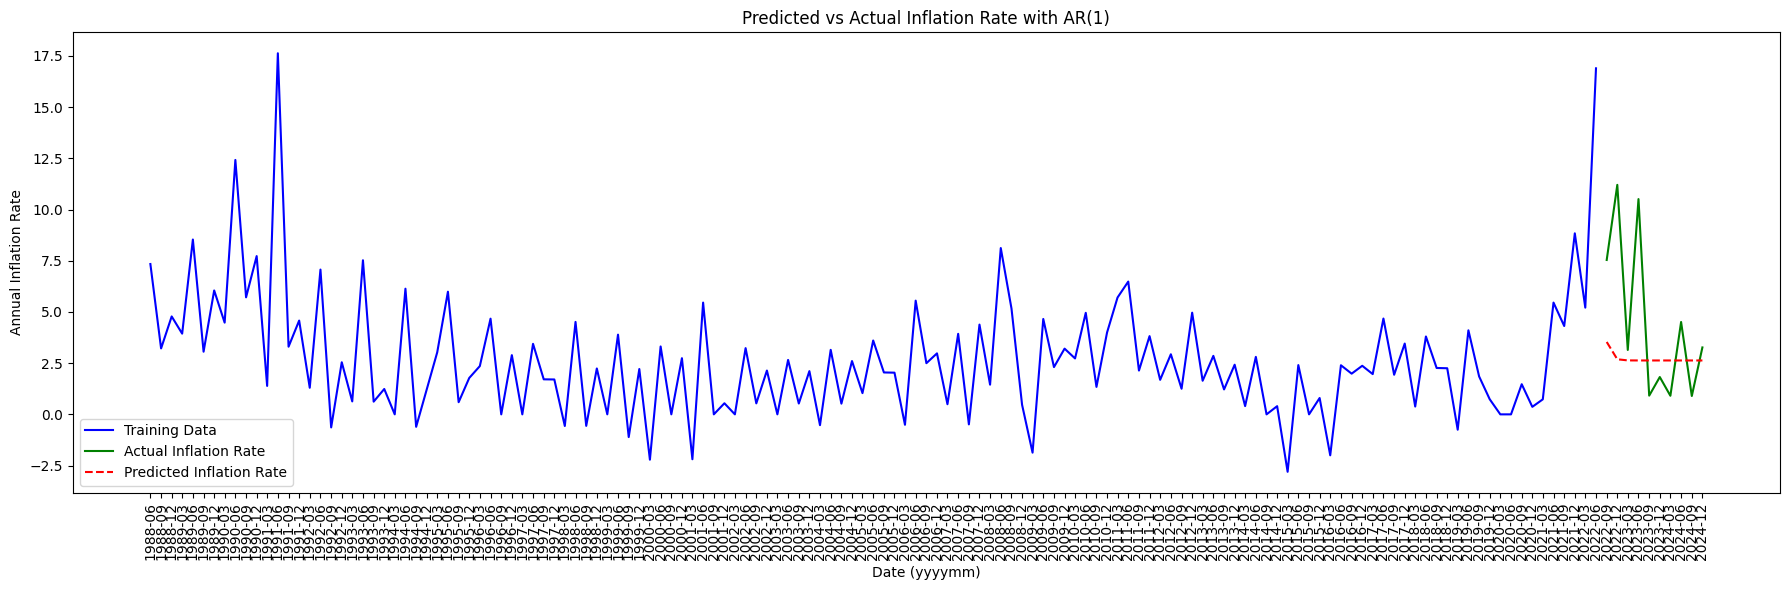

In [15]:
fit_and_predict_AR_model(lags=1)



#Using 6 lags

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


                              AutoReg Model Results                              
Dep. Variable:     Annual Inflation Rate   No. Observations:                  137
Model:                        AutoReg(6)   Log Likelihood                -284.353
Method:                  Conditional MLE   S.D. of innovations              2.121
Date:                   Fri, 04 Apr 2025   AIC                            584.706
Time:                           02:32:16   BIC                            607.708
Sample:                       12-01-1989   HQIC                           594.053
                            - 06-01-2022                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.7020      0.343      2.046      0.041       0.030       1.374
Annual Inflation Rate.L1     0.2857      0.095      2.996      0.

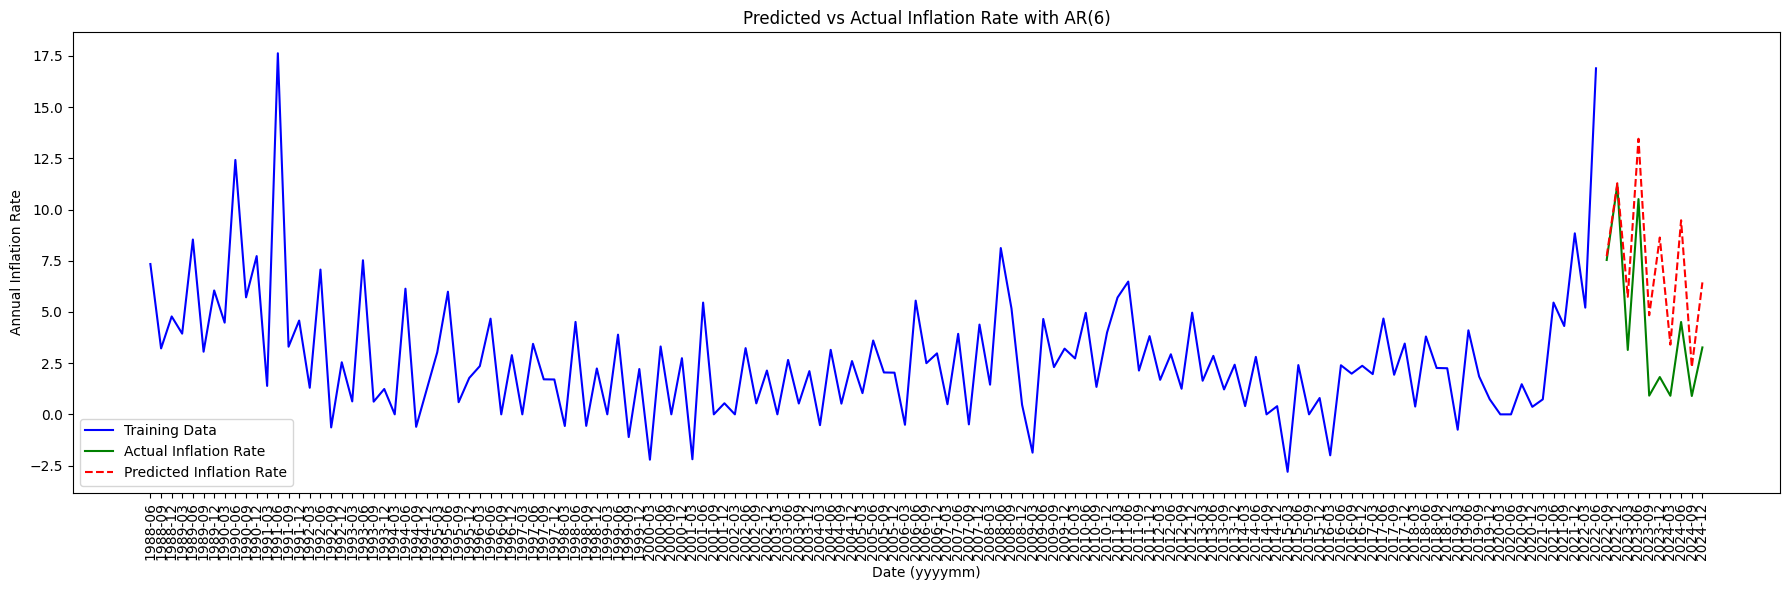

In [16]:
fit_and_predict_AR_model(lags=6)

#Now we try with exogenous variable with ARDL using GDP Quarterly change, Interest Rate Quarterly, and Unemployment Rate Quarterly using 6 lag for CPI inflation rate and 12 lag for exogenous variable

<ipython-input-17-97c1c065a803>:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_gdp = pd.read_csv('/content/drive/MyDrive/UK macro data/GDP Quarterly.csv',sep=';\s*')


     Quarter  Quarterly GDP
0     198803         133283
1     198806         136630
2     198809         140801
3     198812         144969
4     198903         148623
..       ...            ...
143   202312         685749
144   202403         698800
145   202406         707433
146   202409         717089
147   202412         724724

[148 rows x 2 columns]
     Quarter  Interest Rate
0     197503          10.00
1     197506          10.00
2     197509          11.00
3     197512          11.25
4     197603           9.00
..       ...            ...
196   202403           5.25
197   202406           5.25
198   202409           5.00
199   202412           4.75
200   202503           4.50

[201 rows x 2 columns]
       date  Quarterly GDP  Quarterly GDP Change
1    198806         136630              2.480186
2    198809         140801              3.007100
3    198812         144969              2.917238
4    198903         148623              2.489297
5    198906         151262         

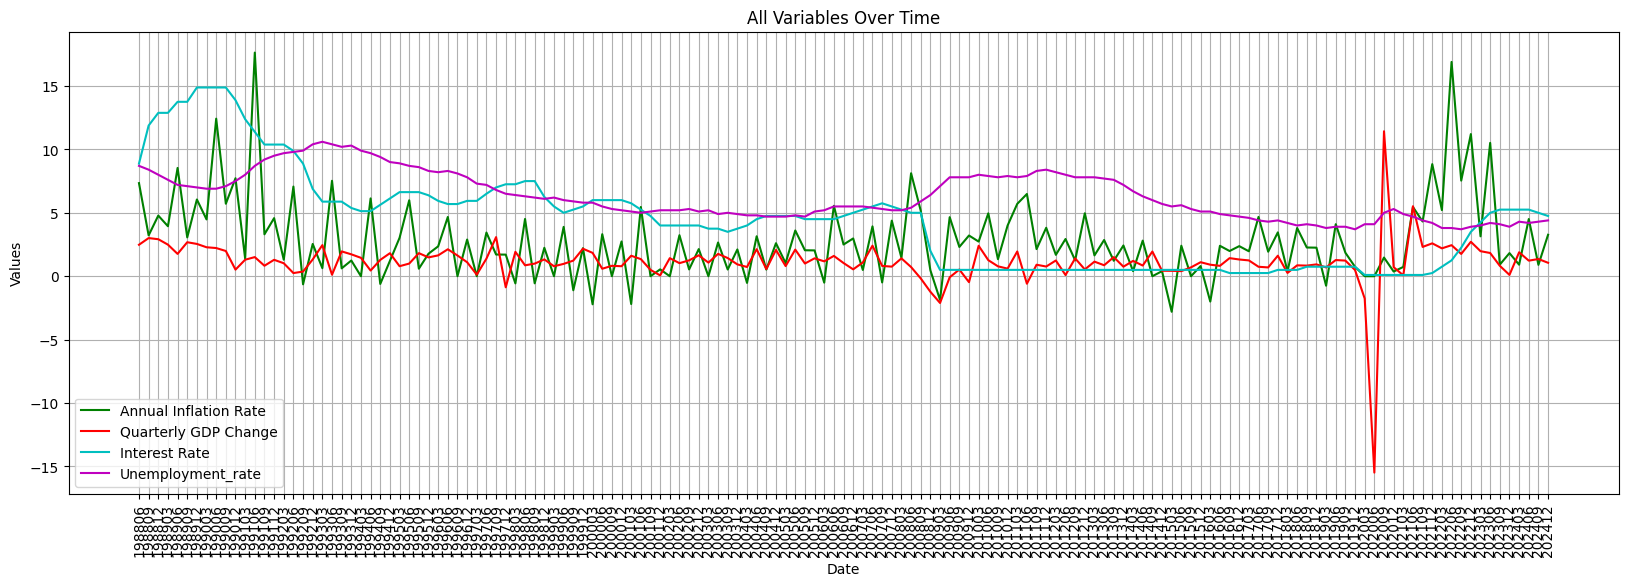

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df_gdp = pd.read_csv('/content/drive/MyDrive/UK macro data/GDP Quarterly.csv',sep=';\s*')
df_interest_rate = pd.read_csv('/content/drive/MyDrive/UK macro data/Interest Rate Quarterly.csv')
df_unemployement = pd.read_csv('/content/drive/MyDrive/UK macro data/Unemployment rate Quarterly.csv')

print(df_gdp)
print(df_interest_rate)
# Rename the date columns for consistency
df_gdp = df_gdp.rename(columns={df_gdp.columns[0]: 'date'})

df_interest_rate = df_interest_rate.rename(columns={df_interest_rate.columns[0]: 'date'})
df_unemployement = df_unemployement.rename(columns={df_unemployement.columns[0]: 'date'})
df_inflation = df_inflation.rename(columns={df_inflation.columns[0]: 'date'})  # Rename index column to 'date'
import numpy as np

# Convert 'Quarterly GDP' column to numeric
df_gdp['Quarterly GDP'] = pd.to_numeric(df_gdp['Quarterly GDP'], errors='coerce')

# Calculate the log quarterly change for GDP
df_gdp['Quarterly GDP Change'] = np.log(df_gdp['Quarterly GDP']).diff() * 100

# Drop the first row with NaN due to differencing
df_gdp.dropna(subset=['Quarterly GDP Change'], inplace=True)

# Display the modified df_gdp
print(df_gdp)


# Ensure all date columns are strings
df_gdp['date'] = df_gdp['date'].astype(str)
df_interest_rate['date'] = df_interest_rate['date'].astype(str)
df_unemployement['date'] = df_unemployement['date'].astype(str)
df_inflation['date'] = df_inflation['date'].astype(str)

# Keep only 'date' and 'Annual Inflation Rate' columns from df_inflation
df_inflation = df_inflation[['date', 'Annual Inflation Rate']]

# Merge all dataframes on 'date'
df_combined = df_inflation.merge(df_gdp, on='date', how='inner') \
                          .merge(df_interest_rate, on='date', how='inner') \
                          .merge(df_unemployement, on='date', how='inner')
# Remove the 'Quarterly GDP' column from df_combined
df_combined = df_combined.drop(columns=['Quarterly GDP'])
print(df_combined)


# Plot all columns on the same graph with different colors
plt.figure(figsize=(20, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y']  # Define some colors
for i, column in enumerate(df_combined.columns):
    if column != 'date':  # Skip the 'date' column
        plt.plot(df_combined['date'], df_combined[column], color=colors[i % len(colors)], label=column)

plt.title('All Variables Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
plt.show()


In [18]:
# Assuming df_combined is your DataFrame
drive.mount('/content/gdrive')
output_path = "/content/gdrive/My Drive/macro_data/df_combined.csv"

# Exporting the DataFrame to a CSV file
df_combined.to_csv(output_path, index=False)


Mounted at /content/gdrive


#Multicolinearity test from correlation matrix

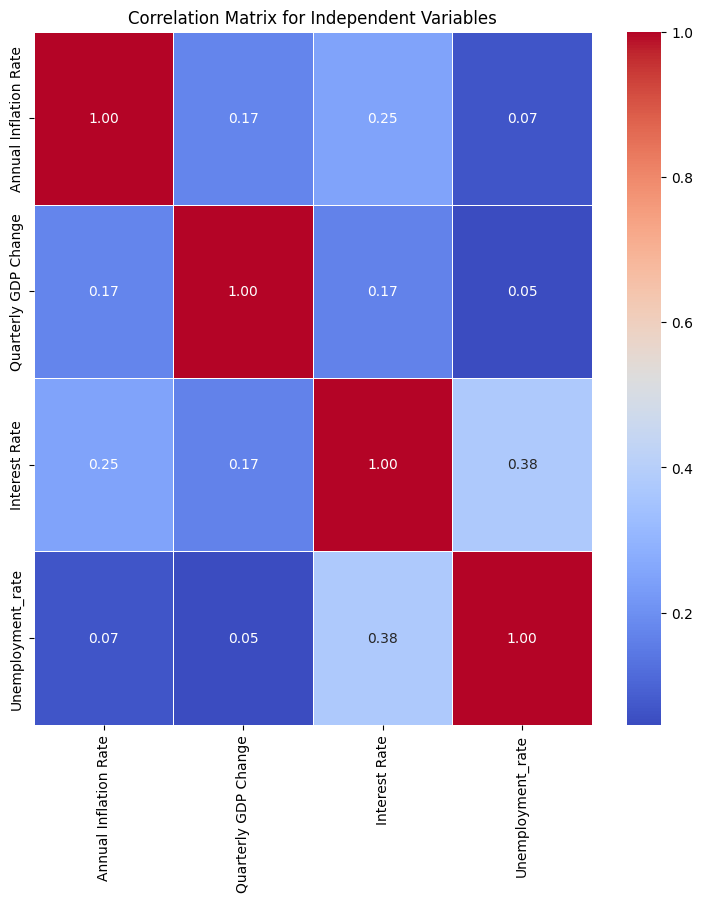

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_combined contains the variables: 'Annual Inflation Rate', 'Quarterly GDP Change', 'Interest Rate', 'Unemployment_rate'
correlation_matrix = df_combined[['Annual Inflation Rate', 'Quarterly GDP Change', 'Interest Rate', 'Unemployment_rate']].corr()

# Plotting the correlation heatmap
plt.figure(figsize=(9, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix for Independent Variables')
plt.show()


#COefficient value for exog and AR variable

The rationale behind using causal=True :
1. Current value of the dependent variable: The future values of the dependent variable (y) can only be predicted based on its past lags (i.e., lagged values of the dependent variable) and the lagged values of the exogenous variables (independent variables), not the current value of the independent variables.

2. Excluding the contemporaneous relationship: If you include the current value of the exogenous variables (i.e., lag 0) when setting causal=False, you are essentially allowing the current value of the exogenous variables to affect the current value of the dependent variable. However, in forecasting, you won't know the future values of these exogenous variables, and so their instantaneous effect is not relevant beyond the last available time point.

In [20]:
import pandas as pd
from statsmodels.tsa.api import ARDL

# Define exogenous variables
exog = df_combined[['Quarterly GDP Change', 'Interest Rate', 'Unemployment_rate']].copy()

# Fit ARDL Model
model = ARDL(df_combined['Annual Inflation Rate'], 11, exog, 7, causal=True)
result = model.fit()

# Display the model summary
print(result.summary())

# Extract p-values and coefficients
pvalues = result.pvalues
coefficients = result.params

# Filter out coefficients with p-values < 0.05
significant_coefs = coefficients[pvalues < 0.05]

# Display the significant coefficients
print("\nSignificant Coefficients with 95% confidence level (p-value < 0.05):")
print(significant_coefs)


                                ARDL Model Results                               
Dep. Variable:     Annual Inflation Rate   No. Observations:                  147
Model:                 ARDL(11, 7, 7, 7)   Log Likelihood                -271.107
Method:                  Conditional MLE   S.D. of innovations              1.776
Date:                   Fri, 04 Apr 2025   AIC                            610.214
Time:                           02:32:24   BIC                            709.244
Sample:                               11   HQIC                           650.457
                                     147                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.9870      0.880      1.122      0.264      -0.758       2.732
Annual Inflation Rate.L1      0.2736      0.101      2.714    

In [21]:
import pandas as pd
import numpy as np


df_combined_prediction = df_combined.copy()

# Convert the 'date' column to datetime format and set it as the index in the new DataFrame
df_combined_prediction['date'] = pd.to_datetime(df_combined_prediction['date'], format='%Y%m')
df_combined_prediction.set_index('date', inplace=True)

# Define Train and Test Sets Using Boolean Indexing
ARDL_train_data = df_combined_prediction.loc[df_combined_prediction.index <= '2022-06-01']


ARDL_test_data = df_combined_prediction.loc[df_combined_prediction.index > '2022-06-01']



In [22]:
import pandas as pd
from statsmodels.tsa.api import ARDL

# Define exogenous variables
exog1 = ARDL_train_data[['Quarterly GDP Change', 'Interest Rate', 'Unemployment_rate']].copy()

# Fit ARDL Model
modeltrain = ARDL(ARDL_train_data['Annual Inflation Rate'], 11, exog1, 7, causal=True)
resultARDL = modeltrain.fit()

# Display the model summary
print(resultARDL.summary())

# Extract p-values and coefficients
pvalues1 = result.pvalues
coefficients1 = result.params

# Filter out coefficients with p-values < 0.05
significant_coefs_ARDL = coefficients1[pvalues < 0.05]

# Display the significant coefficients
print("\nSignificant Coefficients with 95% confidence level (p-value < 0.05):")
print(significant_coefs_ARDL)


                                ARDL Model Results                               
Dep. Variable:     Annual Inflation Rate   No. Observations:                  137
Model:                 ARDL(11, 7, 7, 7)   Log Likelihood                -250.370
Method:                  Conditional MLE   S.D. of innovations              1.765
Date:                   Fri, 04 Apr 2025   AIC                            568.740
Time:                           02:32:24   BIC                            665.174
Sample:                       03-01-1991   HQIC                           607.918
                            - 06-01-2022                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.7728      0.907      0.853      0.396      -1.027       2.573
Annual Inflation Rate.L1      0.2198      0.120      1.829    

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


2022-09-01    5.664676
2022-12-01    7.866713
2023-03-01    3.770757
2023-06-01    9.330039
2023-09-01    2.684171
2023-12-01    5.194067
2024-03-01    2.358617
2024-06-01    7.494480
2024-09-01    1.958264
2024-12-01    3.739919
Freq: QS-DEC, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


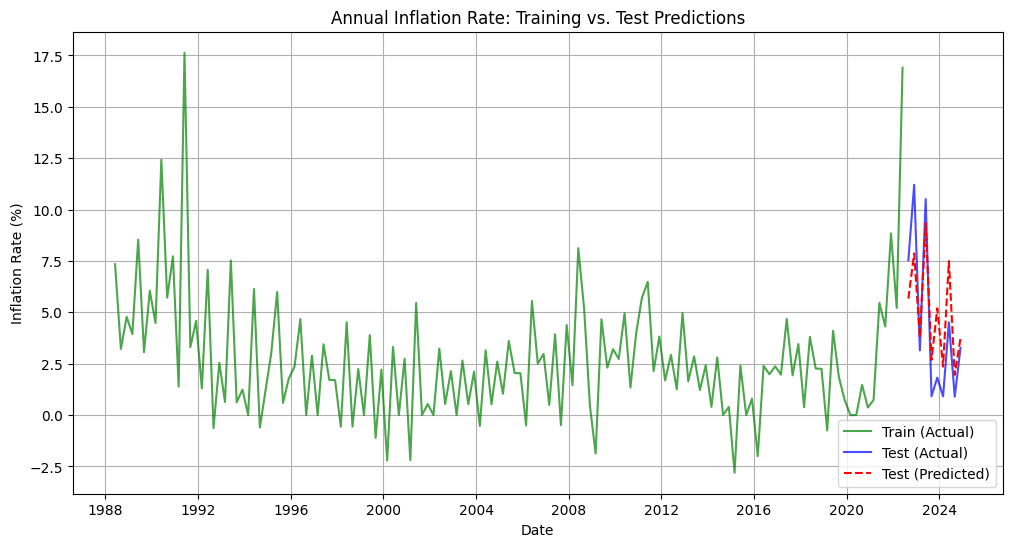

In [23]:
import matplotlib.pyplot as plt

train_inflation = ARDL_train_data['Annual Inflation Rate']

test_inflation = ARDL_test_data['Annual Inflation Rate']


exog_test = ARDL_test_data[['Quarterly GDP Change', 'Interest Rate', 'Unemployment_rate']].copy()
exog_train = ARDL_train_data[['Quarterly GDP Change', 'Interest Rate', 'Unemployment_rate']].copy()


dynamic_predictions = resultARDL.predict(
    start=ARDL_test_data.index[0],
    end=ARDL_test_data.index[-1],
    exog=exog_train,
    exog_oos=exog_test,
    dynamic=False
)


print(dynamic_predictions)

plt.figure(figsize=(12, 6))


plt.plot(ARDL_train_data.index,
         ARDL_train_data['Annual Inflation Rate'],
         label='Train (Actual)', color='green', alpha=0.7)


plt.plot(test_inflation.index,
         test_inflation,
         label='Test (Actual)', color='blue', alpha=0.7)


plt.plot(dynamic_predictions.index,
         dynamic_predictions,
         label='Test (Predicted)', color='red', linestyle='--')


plt.title('Annual Inflation Rate: Training vs. Test Predictions')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)

plt.show()